In [198]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from scipy.sparse import diags
from numpy import linalg as LA
from scipy.sparse.linalg import eigs
import os



In [199]:
def tensor(a,b):
    Data_type = object
    dims_a= a.shape
    dims_b= b.shape
    out= np.zeros(dims_b[0])
    out = np.array(out, dtype=Data_type)

    for n in range(dims_b[0]):
        out[n]= a*b[n][0]
        for m in range(dims_b[1]-1):
            out[n]= np.concatenate((out[n],a*b[n][m+1]),axis=1 )
            print(out[n])
    out= np.array(out)
       

        
        

In [368]:
#How to make tensors with Qutip
a = qt.Qobj(np.diag([1]*2))
b= qt.Qobj(np.array([[0,1],[1,0]]))

c= qt.tensor(a,b)
# c=c.full()
c

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

In [357]:
#Parameters

#Hopping rates
t1=1
t2=2
# Decaying rate = \gamm_l + \gamma_g
gam=2
# System size
L= 12
# Potential 
mass= 0

In [232]:
#Damping Matrix
def Energy2D(kx,ky):
    f= np.exp(1j*(2*np.pi*kx)) + np.exp(1j*(2*np.pi*ky))
    fcc= np.conjugate(f)
    F= f*fcc
    ReE=-gam*0.5
    ImE= np.sqrt( (t1**2 +F*(t2**2) +2*t1*t2*np.real(f) -0.25*gam**2 ) -1j*t2*gam*np.imag(f) +mass**2 ) 
    return  np.array([ ReE +1j*ImE, ReE -1j*ImE ])


In [230]:
#Non-Hermitian Hamiltonian

def Energy2DNH(kx,ky):
    f= np.exp(1j*(2*np.pi*kx)) + np.exp(1j*(2*np.pi*ky))
    fcc= np.conjugate(f)
    F= f*fcc
    ReE=gam*0.5
    ImE= np.sqrt( (t1**2 +F*t2**2 +2*t1*t2*np.real(f) -0.25*gam**2 ) -1j*t2*gam*np.imag(f) +mass**2 ) 
    return  np.array([ ReE +1j*ImE, ReE -1j*ImE ])



In [229]:
#Damping Matrix

def Energy1D(k):
    f= np.exp(1j*(2*np.pi*k)) 
    fcc= np.conjugate(f)
    F= f*fcc
    ReE=-gam*0.5
    ImE= np.sqrt( (t1**2 +t2**2 +2*t1*t2*np.real(f) -0.25*gam**2 ) -1j*t2*gam*np.imag(f) +mass**2 ) 
    return  np.array([ ReE +1j*ImE, ReE -1j*ImE ])



In [228]:
#Non-Hermitian Hamiltonian

def Energy1DNH(k):
    f= np.exp(1j*(2*np.pi*k)) 
    fcc= np.conjugate(f)
    F= f*fcc
    ReE= gam*0.5
    ImE= np.sqrt( (t1**2 +t2**2 +2*t1*t2*np.real(f) -0.25*gam**2 ) -1j*t2*gam*np.imag(f) +mass**2 ) 
    return  np.array([ ReE +1j*ImE, ReE -1j*ImE ])


In [358]:
# OBC/OBC Hamiltonian 
N=L
M= L

S= qt.Qobj(np.array([ [1j*mass-0.5*gam, 1j*t1 - 1j*0.5*gam], [1j*t1 + 1j*0.5*gam,-1j*mass-0.5*gam ] ]))

TNM= qt.Qobj(diags([1,1], [-1, 1], shape=(N*M,N*M)).toarray())
TN= qt.Qobj(diags([1,1], [-1, 1], shape=(N,N)).toarray())
T =qt.Qobj( np.array([ [0,1j*t2],[1j*t2,0] ]) )

INM=qt.Qobj(np.diag([1]*(N*M)) )
IM=qt.Qobj(np.diag([1]*(M)) )


# SI= np.tensordot(I,S, axes=0)
# SI.shape

INM_S= qt.tensor(INM,S).full()
TNM_T= qt.tensor(TNM,T).full()
TN_IM_T= qt.tensor(TN, IM,T).full()

H_OBC=INM_S +TNM_T + TN_IM_T

H_OBC.shape


(288, 288)

In [359]:
# Calculate eigenvalues and eigenvectors for the OBC/OBC damping matrix

EIGen, EIGv= LA.eig(H_OBC)

# Armchair Damping Matrix


$X_{arm}(k)=i\left[ t_1 \cos\left(\frac{k}{2}\right) \sigma_x +\left(t_1 \sin\left(\frac{k}{2}\right)-i\frac{\gamma}{2}\cos\left(\frac{k}{2}\right) \right)\sigma_y \right] + \frac{\gamma}{2}\sin\left(\frac{k}{2} \right)[\sigma_+ -\sigma_-]-\frac{\gamma}{2}\mathcal{I} $


$X_{arm}^{\perp}= it_2\sigma_x$

In [310]:
# Armchair Spectrum OBCx/PBCy


def X_arm(k):
    
    return np.array([[-0.5*gam, 1j*t1*np.cos(0.5*k)\
                              + t1*np.sin(0.5*k)-1j*0.5*gam*np.cos(0.5*k)\
                              + 0.5*gam*np.sin(0.5*k) ],\
                     [  1j*t1*np.cos(0.5*k)\
                      - t1*np.sin(0.5*k) + 1j*0.5*gam*np.cos(0.5*k)\
                      - 0.5*gam*np.sin(0.5*k) , -0.5*gam]])

#Intercell coupling matrix 
X_arm_p= np.array([ [0,1j*t2], [1j*t2,0] ])
    

In [459]:
# Generate the Damping matrix
N=L
M= L

K= np.arange(1, L+1)/L
INM=qt.Qobj(np.diag([1]*(N*M)) )

# Generate the matrix
X_arm_k=[qt.Qobj(X_zz(k)) for k in K]
INM_X= np.array([qt.tensor(INM,x).full() for x in X_arm_k])

T_NM= qt.Qobj(diags([1,1], [-1, 1], shape=(N*M,N*M)).toarray())

Xarmp= np.array([qt.tensor(T_NM,X_zz_p).full()]*len(K))


X= INM_X+ Xarmp

# Zigzag Damping Matrix



$X_{zz}(k)= 2it_2\cos\left(\frac{k}{2}\right) - \frac{\gamma}{2}\mathcal{I}$


$X_{zz}^{\perp}= i(t_1-\frac{\gamma}{2})\sigma_+$


$\tilde{X}_{zz}^{\perp}= i(t_1+\frac{\gamma}{2})\sigma_-$

In [442]:
# Zigzag Spectrum PBCx/OBCy

def X_zz(k):
    
    return np.array([[-0.5*gam,1j*2*np.cos(0.5*k)*t2 ],\
                     [1j*2*np.cos(0.5*k)*t2,-0.5*gam]] )

X_zz_p= qt.Qobj(np.array([ [0,1j*(t1-0.5*gam)], [0,0] ]))
X_zz_pp= qt.Qobj(np.array([ [0,0], [1j*(t1+0.5*gam),0] ]))


In [443]:
N=L
M= L

K= np.arange(1, L+1)/L
INM=qt.Qobj(np.diag([1]*(N*M)) )

# Generate the matrix
X_zz_k=[qt.Qobj(X_zz(k)) for k in K]
INM_X= np.array([qt.tensor(INM,x).full() for x in X_zz_k])

Tup_NM= qt.Qobj(diags([1], [ 1], shape=(N*M,N*M)).toarray())
Tdown_NM= qt.Qobj(diags([1], [-1], shape=(N*M,N*M)).toarray())
Xzzp= np.array([qt.tensor(Tup_NM,X_zz_p).full()]*len(K))
Xzzpp= np.array([qt.tensor(Tdown_NM,X_zz_pp).full()]*len(K))

X= INM_X+ Xzzp+Xzzpp

In [444]:
X.shape

(12, 288, 288)

In [360]:
# Define the home directory and file name
home = "/Users/juan/Desktop/Git/2DLindbladianTopology/"
dir_path = home + "Data/Eigen/"

# Ensure the directory exists; if not, create it
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

# Define the file name
file_name = dir_path + "L_%s_t1_%.2f_t2_%.2f_m%.2f_gamma_%.2f.npz" % (L, t1, t2, mass, gam)

# Save the data
np.savez_compressed(file_name, eigenvalues=EIGen, eigenstates=EIGv)

print(f"Data saved to {file_name}")

Data saved to /Users/juan/Desktop/Git/2DLindbladianTopology/Data/Eigen/L_12_t1_1.00_t2_2.00_m0.00_gamma_2.00.npz


/Users/juan/Desktop/Git/2DLindbladianTopology/Images/Energy/L_12_t1_1.00_t2_2.00_m0.00_gamma_2.00.png


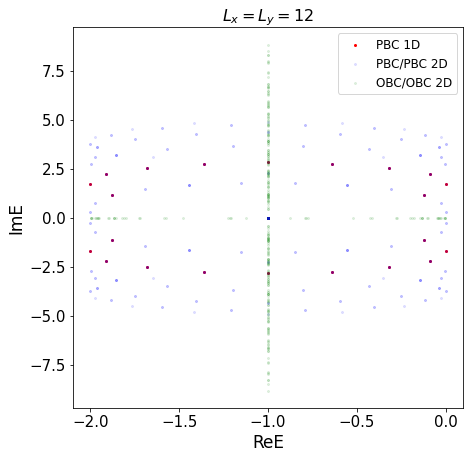

In [366]:
K= np.arange(1, L+1)/L
#Honeycomb lattice PBC/PBC
E2= np.array([[Energy2D(kx,ky) for kx in K ]for ky in K] )
E2= E2.reshape(L*L*2)
ReE2= np.real(E2)
ImE2= np.imag(E2)
#Chiral SSH
E= Energy1D(K) 
ReE= np.real(E)
ImE= np.imag(E)
ReEIGen= np.real(EIGen)
ImEIGen= np.imag(EIGen)
#OBC/OBC
# point size
size= 4


fig = plt.figure(figsize=(7,7)) #Figureを作成    
ax = fig.add_subplot(1,1,1) # Axesを作成
ax.scatter(ReE, ImE, s=size, c='r',label= 'PBC 1D')
ax.scatter(ReE2, ImE2,s=size, c='b', alpha=0.1, label= 'PBC/PBC 2D')
ax.scatter(ReEIGen,ImEIGen,s=size, c='g', alpha=0.1, label= 'OBC/OBC 2D')
ax.set_xlabel('ReE', fontsize= 17)
ax.set_ylabel('ImE', fontsize= 17)
ax.tick_params(labelsize=15)

ax.legend(loc="upper right", fontsize=12)
plt.title(r"$L_x=L_y=%.f$"%L,fontsize=16)

home= "/Users/juan/Desktop/Git/2DLindbladianTopology/"
name = home+"Images/Energy/L_%s"%(L)+"_t1_%.2f_t2_%.2f_m%.2f_gamma_%.2f.png"\
         %(t1,t2,mass,gam)
plt.savefig(name)
print(name)

## spatialdistribution $|ψ(r)|^2$ of the density of the first N right eigenstates $φ_n(r)$ of the OBC Hamiltonian 

$|\psi(r)|^2= \frac{1}{N}\sum_{n=1}^{N} |\phi_n(r)|^2$

In [362]:
#load the data
home = "/Users/juan/Desktop/Git/2DLindbladianTopology/"
dir_path_eig = home + "Data/Eigen/"

# Define the file name
file_name = dir_path_eig + "L_%s_t1_%.2f_t2_%.2f_m%.2f_gamma_%.2f.npz" % (L, t1, t2, mass, gam)

data = np.load(file_name)

# Extract eigenvalues and eigenstates from the loaded data
loaded_EIGen = data['eigenvalues']
loaded_EIGv = data['eigenstates']
print(f"Data saved to {file_name}")



Data saved to /Users/juan/Desktop/Git/2DLindbladianTopology/Data/Eigen/L_12_t1_1.00_t2_2.00_m0.00_gamma_2.00.npz


In [251]:
def wavefunction(l, m, M, eigv):
    #l in [0, N-1], m in [0,2M-1]
    position= 2*l*M+m 
    psi_sq= np.sum(np.abs(eigv[position, :])**2)/len(eigv)
    return psi_sq


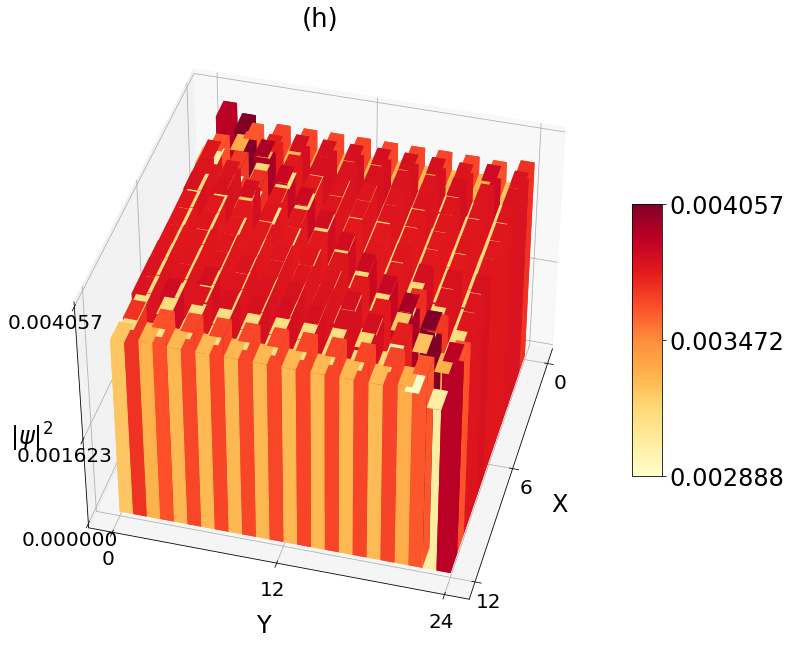

In [363]:
import numpy as np
import matplotlib.pyplot as plt

#fontsize title
ftitle= 26
#fontsize labels
flabel= 24
#setting the size of the system
N=M=L

# Sample data
x = np.arange(0, N)
y = np.arange(0, 2*M)
z = np.zeros((len(x), len(y)))
dx = dy = 0.65
# wavefunction density (N,2M) array

dz= np.fromfunction(np.vectorize(lambda l, m: wavefunction(l, m, M,loaded_EIGv)), (N, 2*M), dtype=int)

'''
example, (N,M)= (4,3) 
dz = [
    [0.02, 0.03, 0.04, 0.05],
    [0.05, 0.06, 0.05, 0.04],
    [0.02, 0.02, 0.03, 0.04]
]
'''

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.set_position([0.2, 0.2, 0.6, 0.6])

xpos, ypos = np.meshgrid(x, y, indexing="ij")
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = z.flatten()
dx = dy = np.ones_like(zpos)
dz = np.array(dz).flatten()

# Create the normalization and colors for the bars
norm = plt.Normalize(dz.min(), dz.max())
# norm = plt.Normalize(0, dz.max())
colors = plt.cm.YlOrRd(norm(dz))
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=False, color=colors)

# Create the colorbar based on the same normalization
mappable = plt.cm.ScalarMappable(norm=norm, cmap='YlOrRd')
mappable.set_array(dz)
min_val = dz.min()
# min_val = 0
max_val = dz.max()
mid_val = (min_val + max_val) / 2

# Get the position of the subplot
pos = ax.get_position()

# Set the position of the colorbar manually
cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0+ 0.16, 0.03, 0.45*pos.height])  # [left, bottom, width, height]
cbar = fig.colorbar(mappable, cax=cbar_ax, orientation='vertical')
cbar.set_ticks([min_val, mid_val, max_val])
cbar.ax.tick_params(labelsize=flabel)

# cbar.set_label(r'$|\psi|^2$', rotation=270, labelpad=15)

ax.set_xticks([0, N/2, N])
ax.set_yticks([0, M, 2*M])
ax.set_zticks([0,  max_val*0.4, max_val])
# ax.set_zticklabels([f"{min_val:.2f}", f"{mid_val:.2f}", f"{max_val:.2f}"], fontsize=flabel)

ax.set_xlabel('X', fontsize=flabel, labelpad=20)
ax.set_ylabel('Y', fontsize=flabel, labelpad=20)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel(r'$|\psi|^2$', rotation=0, va='center', ha='right', fontsize=flabel, labelpad=10)
ax.set_title('(h)', fontsize=ftitle, pad=-5)
ax.view_init(elev=40, azim=15)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.zaxis.set_rotate_label(False)

plt.show()


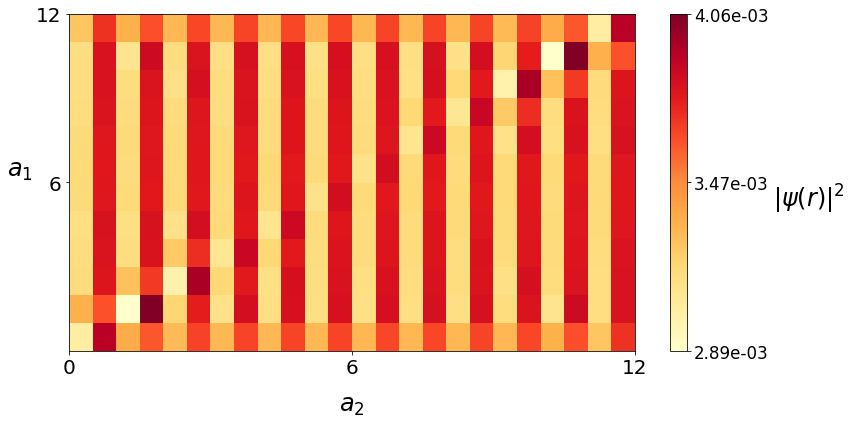

In [364]:
from matplotlib.ticker import FuncFormatter

# Settings
ftitle = 26
flabel = 24
N, M = L, L

# Create the data
dz = np.fromfunction(np.vectorize(lambda l, m: wavefunction(l, m, M, loaded_EIGv)), (N, 2*M), dtype=int)

# Plotting
fig, ax = plt.subplots(figsize=(12,6))

# Display the heatmap
cax = ax.imshow(dz, cmap='YlOrRd', origin='lower', aspect="auto", extent=[0, N, 0, 2*M])

# Create the colorbar
cbar = fig.colorbar(cax)


cbar.set_ticks([min_val, mid_val, max_val])
cbar.ax.tick_params(labelsize=flabel*.7)

# Format the colorbar tick labels to scientific notation
def sci_notation(x, pos):
    return "{:.2e}".format(x)
formatter = FuncFormatter(sci_notation)
cbar.ax.yaxis.set_major_formatter(formatter)

cbar.set_label(r'$|\psi(r)|^2$', rotation=0, labelpad=40, fontsize=flabel)

# Set x-tick positions
ax.set_xticks([0, N/2, N])
# Set y-tick positions
ax.set_yticks([ N, 2*N])
# Set custom y-tick labels
ax.set_yticklabels([str(N//2), str(N)])

ax.set_xlabel(r'$a_2$', fontsize=flabel, labelpad=16)
ax.set_ylabel(r'$a_1$',rotation=360, fontsize=flabel, labelpad=16)
# ax.set_title(r'$|\psi(r)|^2$', fontsize=ftitle, pad=10)
ax.tick_params(axis='both', which='major', labelsize=20)


plt.tight_layout()


# Define the home directory and file name
home = "/Users/juan/Desktop/Git/2DLindbladianTopology/"
dir_path = home + "Images/Density/FullOBC/"

# Ensure the directory exists; if not, create it
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    
name = dir_path+"L_%s"%(L)+"_t1_%.2f_t2_%.2f_m%.2f_gamma_%.2f.png"\
         %(t1,t2,mass,gam)

plt.savefig(name)

plt.show()

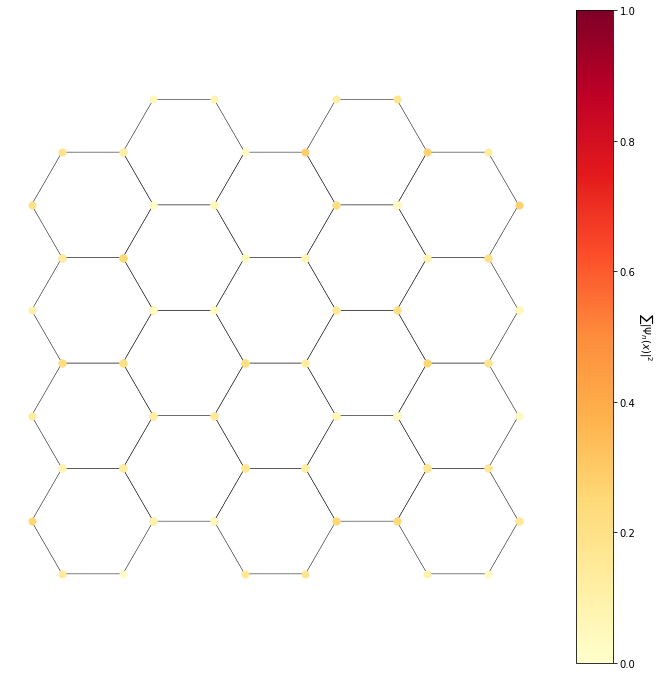

In [452]:
import matplotlib.patches as patches

#Zig-zag or amrchair edges
def hexagon(x_center, y_center, size):
    """Generate coordinates for plotting a hexagon."""
    angle = np.linspace(0, 2*np.pi, 7)
    x_hexagon = x_center + size * np.cos(angle)
    y_hexagon = y_center + size * np.sin(angle)
    return x_hexagon, y_hexagon

# Setting the figure
fig, ax = plt.subplots(figsize=(12,12))
ax.set_aspect('equal')

# Parameters for hexagonal tiling
dx = 3/2
dy = np.sqrt(3)
nx, ny = 5, 4  # number of hexagons in x and y direction

vertices = set()

# Create the hexagonal pattern
for i in range(nx):
    for j in range(ny):
        x = i * dx
        y = j * dy
        # stagger odd rows
        if i % 2 == 1:
            y += dy / 2
        x_hex, y_hex = hexagon(x, y, 1)
        for xi, yi in zip(x_hex, y_hex):
            vertices.add((xi, yi))
        ax.fill(x_hex, y_hex,color='w',edgecolor='black', lw=0.5)

# Adding the white dots at vertices of hexagons
for vertex in vertices:
    
    vertex_color = plt.cm.YlOrRd(np.random.uniform(0, 0.3))
    ax.plot(vertex[0], vertex[1], 'o', markersize=7, color=vertex_color)

# Colorbar
norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation="vertical", aspect=18)
cbar.set_label(r'$\sum |\Psi_n(x)|^2$', rotation=270, labelpad=20)

# # Adding the arrows (Optional based on your image)
# ax.annotate('', xy=(0, -1), xytext=(-3, -1),
#             arrowprops=dict(facecolor='blue', shrink=0.05),
#             )
# ax.annotate('', xy=(9, 6), xytext=(7, 4),
#             arrowprops=dict(facecolor='red', shrink=0.05),
#             )

# Remove axes
ax.axis('off')

plt.show()


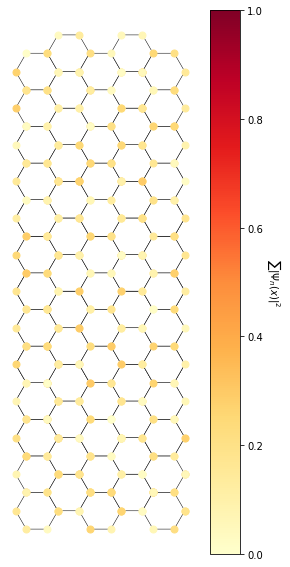

In [458]:
import matplotlib.pyplot as plt
import numpy as np

def hexagon(x_center, y_center, size):
    """Generate coordinates for plotting a hexagon."""
    angle = np.linspace(0, 2*np.pi, 7)
    x_hexagon = x_center + size * np.cos(angle)
    y_hexagon = y_center + size * np.sin(angle)
    return x_hexagon, y_hexagon

N = 5  # Define the number of times you want to replicate the edge

# Setting the figure
fig, ax = plt.subplots(figsize=(6, 2 * N))
ax.set_aspect('equal')

# Parameters for hexagonal tiling
dx = 3/2
dy = np.sqrt(3)
nx = N  # To get the zigzag edge
ny = N

vertices = set()

# Create the hexagonal pattern
for n in range(N):
    for i in range(nx):
        for j in range(ny):
            x = i * dx
            y = (j + n * 2) * dy  # Stacking the zigzag edges
            # stagger odd rows
            if i % 2 == 1:
                y += dy / 2
            x_hex, y_hex = hexagon(x, y, 1)
            for xi, yi in zip(x_hex, y_hex):
                vertices.add((xi, yi))
            ax.fill(x_hex, y_hex, color='w', edgecolor='black', lw=0.5)

# Adding the white dots at vertices of hexagons
for vertex in vertices:
    vertex_color = plt.cm.YlOrRd(np.random.uniform(0, 0.3))
    ax.plot(vertex[0], vertex[1], 'o', markersize=7, color=vertex_color)

# Colorbar
norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation="vertical", aspect=18)
cbar.set_label(r'$\sum |\Psi_n(x)|^2$', rotation=270, labelpad=20)

# Remove axes
ax.axis('off')

plt.show()



In [451]:
angle = np.linspace(0, 2*np.pi, 7)
angle

array([0.        , 1.04719755, 2.0943951 , 3.14159265, 4.1887902 ,
       5.23598776, 6.28318531])

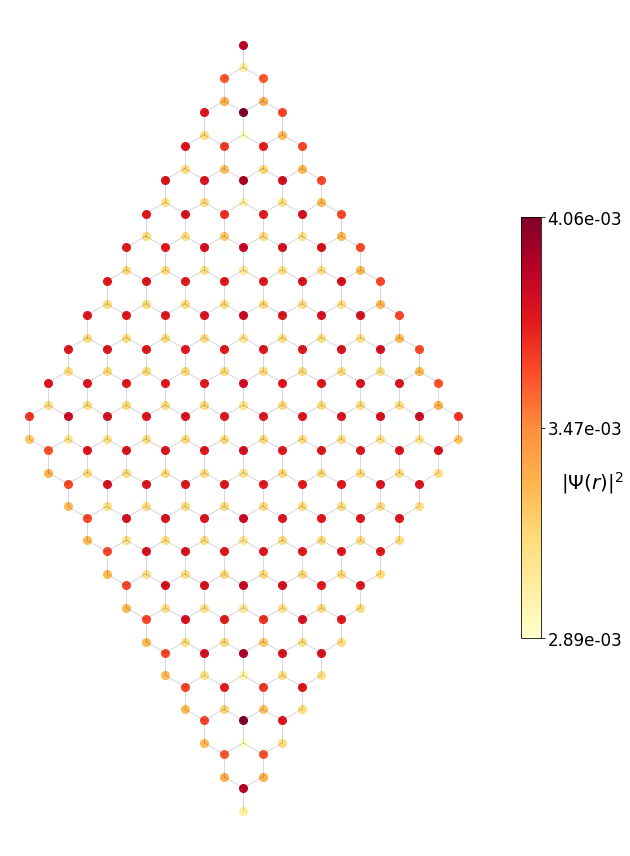

In [446]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
# Setting the figure
fig, ax = plt.subplots(figsize=(12,12))
ax.set_aspect('equal')

# Parameters
N, M = L, L  # number of unit cells in x and y direction
a1 = np.array([np.sqrt(3)*0.5, 3*0.5])
a2 = np.array([-np.sqrt(3)*0.5, 3*0.5])
mark_s= 8 # marker size vor vertices
a= 1 #bond size


vertices = []


# Generate the new tiling
for n in range(N):
    for m in range(N):
        r1 = a1*n + a2*m
        r2 = a1*n + a2*m + a*np.array([0, 1])

        # Add the vertices
        vertices.append((r1[0], r1[1]))
        vertices.append((r2[0], r2[1]))

# Create the data
dz = np.fromfunction(np.vectorize(lambda l, m: wavefunction(l, m, M, loaded_EIGv)), (N, 2*M), dtype=int)      
dz= dz.flatten()

# Normalize dz to range [0, 1] for colormap
norm = plt.Normalize(dz.min(), dz.max())

# Plotting vertices using colors from dz and connecting them with lines
for i, vertex in enumerate(vertices):
    vertex_color = plt.cm.YlOrRd(norm(dz[i]))
    ax.plot(vertex[0], vertex[1], 'o', markersize=mark_s, color=vertex_color, alpha=1)
    
    
    # Connect the current vertex to the next if they are neighbors
    if i % 2 == 0:
        next_vertex = vertices[i + 1]
        ax.plot([vertex[0], next_vertex[0]], [vertex[1], next_vertex[1]], color='black', linestyle='-', lw=0.5,alpha=0.3)
        
        # Connect nearest neighbors 
        r3 = vertex +np.array([-np.sqrt(3)*0.5, -0.5])
        r4 = vertex + np.array([np.sqrt(3)*0.5, -0.5])
        
        # Check conditions to determine whether to draw the lines
        draw_r3 = True
        draw_r4 = True
        
        for m in range(N):
            if np.allclose(vertex, m * a2):
                draw_r3 = False
        for n in range(N):
            if np.allclose(vertex, n * a1):
                draw_r4 = False
                
        if draw_r3:
            ax.plot([vertex[0], r3[0]], [vertex[1], r3[1]], color='black', linestyle='-', lw=0.5,alpha=0.3)
        if draw_r4:
            ax.plot([vertex[0], r4[0]], [vertex[1], r4[1]], color='black', linestyle='-', lw=0.5, alpha=0.3)

# Colorbar

sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation="vertical", aspect=22, shrink= 0.5)

cbar.set_label(r'$|\Psi(r)|^2$', rotation=0, labelpad=-30, fontsize=20)
# Adjust the y attribute of the label's position
label_position = cbar.ax.yaxis.label.get_position()
cbar.ax.yaxis.label.set_position((label_position[0], label_position[1] - 0.1))

min_val = dz.min()
max_val = dz.max()
mid_val = (min_val + max_val) / 2
cbar.set_ticks([min_val, mid_val, max_val])
cbar.ax.tick_params(labelsize=flabel*.7)

# Format the colorbar tick labels to scientific notation
def sci_notation(x, pos):
    return "{:.2e}".format(x)

formatter = FuncFormatter(sci_notation)
cbar.ax.yaxis.set_major_formatter(formatter)

# Remove axes
ax.axis('off')

plt.tight_layout()


# Define the home directory and file name
home = "/Users/juan/Desktop/Git/2DLindbladianTopology/"
dir_path = home + "Images/Density/FullOBC/"

# Ensure the directory exists; if not, create it
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    
name = dir_path+"Grid_L_%s"%(L)+"_t1_%.2f_t2_%.2f_m%.2f_gamma_%.2f.png"\
         %(t1,t2,mass,gam)

plt.savefig(name)

plt.show()
